# Bi-Directional Attention Flow Model

#### Set Checkpoint and Data Folder

In [ ]:
!pip install -U PyYAML
!pip install -U h5py
!pip install pytorch-lightning
!pip install matplotlib

In [1]:
import sys, os
import torch
pwd = os.getcwd()

class Arguments():
    data = os.path.join(pwd, 'DATA', 'train_v2.1.json')
    exp_folder = os.path.join(pwd, 'Experimente/EarlyStoppingAdaDelta')
    word_rep = os.path.join(pwd, 'DATA', 'glove.840B.300d.txt')
    #word_rep = None
    cuda = torch.cuda.is_available()
    use_covariance = False
    force_restart = False
    train_original_data = os.path.join(pwd, 'DATA', 'train_v2.1.json')
    train_splitted_data = os.path.join(pwd, 'DATA', 'train_part.json')
    val_data = os.path.join(pwd, 'DATA', 'dev_v2.1.json')
    test_splitted_data = os.path.join(pwd, 'DATA', 'eval_part.json')
    val_splitted_data = os.path.join(pwd, 'DATA', 'dev_part.json')
    test_reference_file = os.path.join(pwd, 'DATA', 'test_reference.json')

args = Arguments()

if not os.path.exists(args.exp_folder):
    os.makedirs(args.exp_folder)


#### Global Configurations (instead of config.yaml)

In [2]:
import yaml

config_yaml = """
    bidaf:
        dropout: 0.2
        num_highways: 2
        num_lstm: 2
        hidden_size: 100
        embedding_dim: 300
        embedding_reduce: 100
        characters:
            dim: 16
            num_filters: 100
            filter_sizes:
                - 5
    training:
        lr: 0.001
        betas:
            - 0.9
            - 0.999
        eps: 0.00000001
        weigth_decay: 0
        epochs: 1
        batch_size: 60
        limit: 400
"""
config = yaml.load(config_yaml, Loader=yaml.FullLoader)


#### Importing the MSMARCO Bidaf Model

In [3]:
sys.path.append(os.path.join(pwd,'MsmarcoQuestionAnswering','Baseline'))
sys.path.append(os.path.join(pwd,'MsmarcoQuestionAnswering','Baseline','scripts'))
sys.path.append(os.path.join(pwd,'MsmarcoQuestionAnswering','Evaluation'))

import MsmarcoQuestionAnswering.Baseline.scripts.checkpointing as checkpointing
import MsmarcoQuestionAnswering.Baseline.scripts.train as train_manager
import MsmarcoQuestionAnswering.Evaluation.ms_marco_eval as eval_manager
#import MsmarcoQuestionAnswering.Baseline.scripts.predict as predict_manager
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import h5py

In [4]:
import MsmarcoQuestionAnswering.Baseline.mrcqa as mrcqa
import MsmarcoQuestionAnswering.Baseline.scripts.dataset as dataset
import json as json
import numpy as np
from random import shuffle, randint

def try_to_split_testset(percentual_size_test, reduced_whole_size=1, force_renew=False):
    if os.path.isfile(args.train_splitted_data) and os.path.isfile(args.test_splitted_data) and os.path.isfile(args.val_splitted_data) and not force_renew:
        return;
    else:
        args.force_restart = True
        with open(args.train_original_data) as f_o:
            train_json = json.load(f_o);
        qids = list(train_json['query_id'].keys());
        shuffle(qids);
        train_size = len(qids)
        train_size = int(reduced_whole_size * train_size)
        new_train_size = int((1 - percentual_size_test) * train_size)
        new_test_size = train_size - new_train_size
        print("New Train Set has {} Datapoints".format(new_train_size))
        print("New Test Set has {} Datapoints".format(new_test_size))

        
        qids_train = qids[0:new_train_size]
        qids_test = qids[new_train_size:train_size]
        
        def copy_dict_part(old_dict, qids):
            count = 0;
            new_dict = dict()
            keys = old_dict.keys()
            for qid in qids:
                count = count + 1;
                if count % 10000 == 0:
                    print('Copy progress: {}'.format(count/len(qids)))
                for key in keys:
                    if not key in new_dict:
                        new_dict[key] = dict()
                    new_dict[key][qid] = train_json[key][qid]
            return new_dict;
        
        print('Start creating new train set:')
        new_train = copy_dict_part(train_json, qids_train)
        print('Start creating new test set:')
        new_test = copy_dict_part(train_json, qids_test)
        
        with open(args.train_splitted_data, 'w') as write_f:
            write_f.write(json.dumps(new_train))
        with open(args.test_splitted_data, 'w') as write_f:
            write_f.write(json.dumps(new_test))
        
        create_reference_file(new_test, args.test_reference_file)
            
        with open(args.val_data) as f_o:
            val_json = json.load(f_o);
        qids = list(val_json['query_id'].keys())
        shuffle(qids)
        val_size = len(qids)
        new_val_size = int(reduced_whole_size * val_size)
        print("New Validation Set has {} Datapoints".format(new_val_size))

        qids_val = qids[0:new_val_size]
        print('Start creating new val set:')
        new_val = copy_dict_part(val_json, qids_val)
        with open(args.val_splitted_data, 'w') as write_f:
            write_f.write(json.dumps(new_val))
            
def load_data(path,limit):
    with open(path) as f_o:
        data, _ = dataset.load_data(json.load(f_o), span_only=True, answered_only=True, loading_limit=limit)
    return data

def create_reference_file(data_obj, reference_file_path):
        print("Create test reference file")
        with open(reference_file_path, 'w+') as write_f:
            for qid in data_obj["answers"]:
                try:
                    correct = {"query_id": str(qid)}
                    correct["answers"] = data_obj["answers"][str(qid)]
                    write_f.write(json.dumps(correct))
                    write_f.write("\n")
                except KeyError:
                    print("Key Error: "+str(obj["query_id"]))
        print("Done creating reference file")

def init_model(id_to_token, id_to_char):
    return mrcqa.BidafModel.from_config(config['bidaf'], id_to_token, id_to_char)

def reload_model(checkpoint):
    model, id_to_token, id_to_char = mrcqa.BidafModel.from_checkpoint(config['bidaf'], checkpoint)
    if torch.cuda.is_available() and args.cuda:
        model.cuda()
    model.train()
    return model, id_to_token, id_to_char

def inverse_dict(base_dict):
    return {tok: id_ for id_, tok in base_dict.items()}

def get_loader(data, config, used_data_per_batch=1.0):
    data = dataset.EpochGen(
        data,
        batch_size=config.get('training', {}).get('batch_size', 32),
        shuffle=True,
        used_data_per_batch=used_data_per_batch)
    return data

def get_optimizer(model, config, state):
    """
    Get the optimizer
    """
    parameters = filter(lambda p: p.requires_grad,
                        model.parameters())
    """ ADAM Optimizer
    optimizer = torch.optim.Adam(
        parameters,
        lr=config['training'].get('lr', 0.01),
        betas=config['training'].get('betas', (0.9, 0.999)),
        eps=config['training'].get('eps', 1e-8),
        weight_decay=config['training'].get('weight_decay', 0))
    
    """
    
    """ ADAGRAD Optimizer
    optimizer = torch.optim.Adagrad(
        parameters,
        lr=config['training'].get('lr', 0.01),
        weight_decay=config['training'].get('weight_decay', 0))
    """ 
    """ ADADELTA Optimizer """
    optimizer = torch.optim.Adadelta(
        parameters,
        lr=0.5)
    
    if state is not None:
        optimizer.load_state_dict(state)

    return optimizer

def load_pretrained_embeddings(path, model, id_to_token):
    with open(path) as f_o:
            pre_trained = dataset.SymbolEmbSourceText(f_o, set(tok for id_, tok in id_to_token.items() if id_ != 0))
    mean, cov = pre_trained.get_norm_stats(args.use_covariance)
    rng = np.random.RandomState(2)
    oovs = dataset.SymbolEmbSourceNorm(mean, cov, rng, args.use_covariance)
    model.embedder.embeddings[0].embeddings.weight.data = torch.from_numpy(dataset.symbol_injection(id_to_token, 0, model.embedder.embeddings[0].embeddings.weight.data.numpy(), pre_trained, oovs))

In [5]:
def new_init(train_path, val_path, test_path, config, args, loading_limit=None, used_data_per_train_batch=1.0):
    token_to_id = {'': 0}
    char_to_id = {'': 0}
    print('Load Train Data [1/6]')
    train_data = load_data(train_path,loading_limit)
    print('Load Validation Data [1/6]')
    val_data = load_data(val_path,loading_limit)
    print('Load Test Data [1/6]')
    test_data = load_data(test_path,loading_limit)
    
    print('Tokenize Train Data [2/6]')
    train_data = dataset.tokenize_data(train_data, token_to_id, char_to_id)
    print('Tokenize Validation Data [2/6]')
    val_data = dataset.tokenize_data(val_data, token_to_id, char_to_id)
    print('Tokenize Test Data [2/6]')
    test_data = dataset.tokenize_data(test_data, token_to_id, char_to_id)
    
    train_loader = get_loader(train_data, config, used_data_per_batch=used_data_per_train_batch)
    val_loader = get_loader(val_data, config, used_data_per_batch=used_data_per_train_batch)
    test_loader = get_loader(test_data, config)

    print('Create Inverse Dictionaries [3/6]')
    id_to_token = inverse_dict(token_to_id)
    id_to_char = inverse_dict(char_to_id)

    print('Initiate Model [4/6]')
    model = init_model(id_to_token, id_to_char)

    if args.word_rep:
        print('Load pre-trained embeddings [5/6]')
        load_pretrained_embeddings(args.word_rep, model, id_to_token)
    else:
        print('No pre-trained embeddings given [5/6]')
        pass  # No pretraining, just keep the random values.

    if torch.cuda.is_available() and args.cuda:
        model.cuda()
    model.train()

    optimizer = get_optimizer(model, config, state=None)
    print('Done init_state [6/6]')
    return model, id_to_token, id_to_char, optimizer, train_loader, val_loader, test_loader   


def new_reload(train_path, val_path, test_path, checkpoint, training_state, config, args,loading_limit=None, used_data_per_train_batch=1.0):
    print('Load Model from Checkpoint [1/5]')
    model, id_to_token, id_to_char = reload_model(checkpoint)

    optimizer = get_optimizer(model, config, training_state)

    print('Create Inverse Dictionaries [2/5]')
    token_to_id = inverse_dict(id_to_token)
    char_to_id = inverse_dict(id_to_char)

    len_tok_voc = len(token_to_id)
    len_char_voc = len(char_to_id)

    print('Load Train Data [3/5]')
    train_data = load_data(train_path,loading_limit)
    print('Load Validation Data [3/5]')
    val_data = load_data(val_path,loading_limit)
    print('Load Test Data [3/5]')
    test_data = load_data(test_path,loading_limit)
    
    limit_passage = config.get('training', {}).get('limit')

    print('Tokenize Train Data [4/5]')
    train_data = dataset.tokenize_data(train_data, token_to_id, char_to_id)
    print('Tokenize Validation Data [4/5]')
    val_data = dataset.tokenize_data(val_data, token_to_id, char_to_id)
    print('Tokenize Test Data [4/5]')
    test_data = dataset.tokenize_data(test_data, token_to_id, char_to_id)

    train_loader = get_loader(train_data, config, used_data_per_batch=used_data_per_train_batch)
    val_loader = get_loader(val_data, config)
    test_loader = get_loader(test_data, config)

    assert len(token_to_id) == len_tok_voc
    assert len(char_to_id) == len_char_voc

    print('Done reload_state [5/5]')
    return model, id_to_token, id_to_char, optimizer, train_loader, val_loader, test_loader


#### Pytorch Lightning Wrapper

In [6]:
try_to_split_testset(0.1,1, False); #We use 100% of the given Data. And 10% of the Training Data will be used as Test Data. True means force rewrite Datasets.

checkpoint_w, training_state_w, epoch_w = train_manager.try_to_resume(
            args.force_restart, args.exp_folder)

if checkpoint_w:
    print('Resuming training...')
    model_w, id_to_token_w, id_to_char_w, optimizer_w, train_loader, val_loader, test_loader = new_reload(args.train_splitted_data, args.val_splitted_data, 
                                                                                                          args.test_splitted_data, checkpoint_w, 
                                                                                                          training_state_w, config, args, used_data_per_train_batch=0.1)
else:
    print('Preparing to train...')
    model_w, id_to_token_w, id_to_char_w, optimizer_w, train_loader, val_loader, test_loader = new_init(args.train_splitted_data, args.val_splitted_data, 
                                                                                                        args.test_splitted_data,config, args, used_data_per_train_batch=0.1)
    checkpoint_w = h5py.File(os.path.join(args.exp_folder, 'checkpoint'))
    checkpointing.save_vocab(checkpoint_w, 'vocab', id_to_token_w)
    checkpointing.save_vocab(checkpoint_w, 'c_vocab', id_to_char_w)

if torch.cuda.is_available() and args.cuda:
    train_loader.tensor_type = torch.cuda.LongTensor
    val_loader.tensor_type = torch.cuda.LongTensor
    test_loader.tensor_type = torch.cuda.LongTensor

Preparing to train...
Load Train Data [1/6]
Start Organizing Data...
Organizing progress: 0.0 x 10⁴
Organizing progress: 1.0 x 10⁴
Organizing progress: 2.0 x 10⁴
Organizing progress: 3.0 x 10⁴
Organizing progress: 4.0 x 10⁴
Organizing progress: 5.0 x 10⁴
Organizing progress: 6.0 x 10⁴
Organizing progress: 7.0 x 10⁴
Organizing progress: 8.0 x 10⁴
Organizing progress: 9.0 x 10⁴
Organizing progress: 10.0 x 10⁴
Organizing progress: 11.0 x 10⁴
Organizing progress: 12.0 x 10⁴
Organizing progress: 13.0 x 10⁴
Organizing progress: 14.0 x 10⁴
Organizing progress: 15.0 x 10⁴
Organizing progress: 16.0 x 10⁴
Organizing progress: 17.0 x 10⁴
Organizing progress: 18.0 x 10⁴
Organizing progress: 19.0 x 10⁴
Organizing progress: 20.0 x 10⁴
Organizing progress: 21.0 x 10⁴
Organizing progress: 22.0 x 10⁴
Organizing progress: 23.0 x 10⁴
Organizing progress: 24.0 x 10⁴
Organizing progress: 25.0 x 10⁴
Organizing progress: 26.0 x 10⁴
Organizing progress: 27.0 x 10⁴
Organizing progress: 28.0 x 10⁴
Organizing pr

/home/julian/Development/PythonEnv/pytorch/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Load pre-trained embeddings [5/6]
Embeddings Loaded: 0.0 Mio / 2.1 Mio
Embeddings Loaded: 0.1 Mio / 2.1 Mio
Embeddings Loaded: 0.2 Mio / 2.1 Mio
Embeddings Loaded: 0.3 Mio / 2.1 Mio
Embeddings Loaded: 0.4 Mio / 2.1 Mio
Embeddings Loaded: 0.5 Mio / 2.1 Mio
Embeddings Loaded: 0.6 Mio / 2.1 Mio
Embeddings Loaded: 0.7 Mio / 2.1 Mio
Embeddings Loaded: 0.8 Mio / 2.1 Mio
Embeddings Loaded: 0.9 Mio / 2.1 Mio
Embeddings Loaded: 1.0 Mio / 2.1 Mio
Embeddings Loaded: 1.1 Mio / 2.1 Mio
Embeddings Loaded: 1.2 Mio / 2.1 Mio
Embeddings Loaded: 1.3 Mio / 2.1 Mio
Embeddings Loaded: 1.4 Mio / 2.1 Mio
Embeddings Loaded: 1.5 Mio / 2.1 Mio
Embeddings Loaded: 1.6 Mio / 2.1 Mio
Embeddings Loaded: 1.7 Mio / 2.1 Mio
Embeddings Loaded: 1.8 Mio / 2.1 Mio
Embeddings Loaded: 1.9 Mio / 2.1 Mio
Embeddings Loaded: 2.0 Mio / 2.1 Mio
Embeddings Loaded: 2.1 Mio / 2.1 Mio
Done init_state [6/6]


<ipython-input-6-d0f8574f1204>:15: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  checkpoint_w = h5py.File(os.path.join(args.exp_folder, 'checkpoint'))


Fast change Optimizer

In [ ]:
optimizer_w = get_optimizer(model_w, config, None)

In [7]:
epoch_saves = dict();
epoch_saves['train_loss'] = []
epoch_saves['val_loss'] = []
epoch_saves['test_loss'] = []

#Used for test evaluation
qid2candidate = {}

import re
regex_drop_char = re.compile('[^a-z0-9\s]+')
regex_multi_space = re.compile('\s+')

class BidafLightningWrapper(LightningModule):
    def __init__(self):
        super().__init__()
        
    def setup(self,stage):
        pass;
            
    def prepare_data(self):
        pass;

    def configure_optimizers(self):
        return optimizer_w;

    def forward(self, passage, p_lengths, question, q_lengths):
        return model_w(passage, p_lengths, question, q_lengths)

    def train_dataloader(self):
        return train_loader;
    
    def val_dataloader(self):
        return val_loader;
    
    def test_dataloader(self):
        return test_loader;

    def training_step(self, batch, batch_idx):
        qids, passages, queries, answers, _ = batch
        start_log_probs, end_log_probs = self(passages[:2], passages[2], queries[:2], queries[2])
        loss = model_w.get_loss(start_log_probs, end_log_probs, answers[:, 0], answers[:, 1])
        return {'loss': loss, 'train_loss': loss, 'log': {'train_loss': loss}}

    def training_epoch_end(self, results):
        checkpointing.checkpoint(model_w, epoch_w, optimizer_w, checkpoint_w, args.exp_folder)
        model_w.cuda()
        mean_loss = self.save_statistics('train',results)
        return {'log': {'train_loss': mean_loss}}
    
    def validation_step(self, batch, batch_idx):
        qids, passages, queries, answers, _ = batch
        start_log_probs, end_log_probs = self(passages[:2], passages[2], queries[:2], queries[2])
        loss = model_w.get_loss(start_log_probs, end_log_probs, answers[:, 0], answers[:, 1])
        return {'val_loss': loss, 'log': {'val_loss': loss}}
    
    def validation_epoch_end(self, results):
        val_loss_mean = self.save_statistics('val',results)
        return {'val_loss': val_loss_mean}
    
    def test_step(self, batch, batch_idx):
        qids, passages, queries, answers, mappings = batch
        start_log_probs, end_log_probs = self(passages[:2], passages[2], queries[:2], queries[2])
        loss = model_w.get_loss(start_log_probs, end_log_probs, answers[:, 0], answers[:, 1])

        predictions = model_w.get_best_span(start_log_probs, end_log_probs)
        predictions = predictions.cpu()
        passages = passages[0].cpu().data
        for qid, mapping, tokens, pred in zip(qids, mappings, passages, predictions):
            toks = tokens[pred[0]:pred[1]]
            start = mapping[pred[0], 0]
            end = mapping[pred[1]-1, 1]
            toks = regex_multi_space.sub(' ', regex_drop_char.sub(' ', ' '.join(id_to_token_w[int(tok)] for tok in toks).lower())).strip()
            if qid not in qid2candidate:
                qid2candidate[qid] = []
            qid2candidate[qid].append(str(toks))
        return {'test_loss': loss}

    def test_epoch_end(self, results):
        no_ans_set = set()
        out_dict = {}
        
        #print("\t no answer set")
        for qid in qid2candidate:
            if len(qid2candidate[qid]) < 1 or 'No Answer Present.' in qid2candidate[qid]:
                no_ans_set.add(qid)
        #print("\t take random answer from possible ones")
        for qid in qid2candidate:
            pick = randint(0,len(qid2candidate[qid])-1)
            out_dict[qid] = [qid2candidate[qid][pick]]
        
        mean_test_loss = self.save_statistics('test',results)
        test_metrics = eval_manager.compute_metrics_from_model(args.test_reference_file, out_dict, no_ans_set)
        outputfile = os.path.join(args.exp_folder,'metrics.json')
        with open(outputfile,'w+') as f_o:
            f_o.write(json.dumps(test_metrics))
        return {'log': {'test_loss': mean_test_loss}.update(test_metrics)}

    def save_statistics(self, phase, results):
        key = phase + '_loss'
        mean_loss = torch.stack([step[key] for step in results]).mean()
        print("Mean {} Loss: {}".format(phase,mean_loss))
        #print(epoch_saves.keys())
        epoch_saves[key].append([step[key] for step in results])
        return mean_loss



Start new Training

In [8]:
from pytorch_lightning.callbacks import EarlyStopping

modelLightning = BidafLightningWrapper()
early_stopping = EarlyStopping('val_loss')
trainer = Trainer(early_stop_callback=early_stopping, gpus=1)
trainer.fit(modelLightning)
trainer.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------


Epoch 1:  91%|█████████ | 525/576 [03:01<00:17,  2.89it/s, loss=3.990, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 576/576 [03:14<00:00,  2.97it/s, loss=3.990, v_num=0]
                                                           Mean train Loss: 4.597168922424316
Epoch 2:  91%|█████████ | 525/576 [03:03<00:17,  2.85it/s, loss=3.491, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 576/576 [03:16<00:00,  2.93it/s, loss=3.491, v_num=0]
                                                           Mean train Loss: 3.7161266803741455
Epoch 3:  91%|█████████ | 525/576 [03:03<00:17,  2.86it/s, loss=3.270, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 576/576 [03:16<00:00,  2.92it/s, loss=3.270, v_num=0]
                                                           Mean train Loss: 3.3076510429382324
Epoch 4:  91%|█████████ | 525/576 [03:06<00:18,  2.82it/s, loss=3.079, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 576/57

/home/julian/Development/QuestionAnweringProject/MSMARCO-Question-Answering/MsmarcoQuestionAnswering/Evaluation/ms_marco_eval.py:167: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  answersimilarity += candidate_answer.similarity(nlp(answer))


TypeError: 'NoneType' object is not iterable

Load Checkpoint and resume Training

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping

modelLightning = BidafLightningWrapper()
early_stopping = EarlyStopping('val_loss')
trainer = Trainer(early_stop_callback=early_stopping, gpus=1, resume_from_checkpoint= os.path.join(args.exp_folder,"checkpoint.ckpt"))
trainer.fit(modelLightning)
#trainer.test()

Save Pytorch Lightning Checkpoint

In [9]:
trainer.save_checkpoint(os.path.join(args.exp_folder,"checkpoint.ckpt"))

#### Save Loss to statistics.json (to be executed directly after training)

In [10]:
from pathlib import Path
outputfile = os.path.join(args.exp_folder,'statistics.json')
Path(outputfile).touch()

In [11]:
def writeStatisticToDict(key, output_dict, start_epoch = 0):
    output_dict[key] = dict()
    stat_saves = epoch_saves[key]

    for idx in range(0 + start_epoch,len(stat_saves)+start_epoch):
        output_dict[key][idx] = dict()
        for jdx in range(0,len(stat_saves[idx])):
            output_dict[key][idx][jdx] = stat_saves[idx][jdx].item() 

In [12]:
output_dict = dict()

writeStatisticToDict('train_loss',output_dict)
writeStatisticToDict('val_loss',output_dict)
writeStatisticToDict('test_loss',output_dict)

with open(outputfile, 'w') as write_f:
    write_f.write(json.dumps(output_dict))

#### Load Loss from statistics.json

In [13]:
with open(outputfile, 'r') as read_f:
    statistics = json.load(read_f)

Plot per Epoch Mean Loss

In [14]:
from matplotlib import pyplot as plt

def visualizeEpochMeanLoss(key, stats, skip_first=False):
    epoch_stats_dict = stats[key]
    mean_loss = []
    var_loss = []
    first = True
    for epochNum in epoch_stats_dict:
        if first and skip_first:
            first = False
            continue
        epoch_stats = epoch_stats_dict[epochNum].values()
        epoch_stats = np.array(list(epoch_stats))
        mean_loss_in_actual_epoch = np.average(epoch_stats)
        mean_loss = mean_loss + [mean_loss_in_actual_epoch]
        variance_loss_in_actual_epoch = np.var(epoch_stats)
        var_loss = var_loss + [variance_loss_in_actual_epoch]
    
    x = np.arange(0,len(epoch_stats_dict.keys()) - skip_first)
    plt.errorbar(x, mean_loss, yerr=var_loss, label = key)
    
def visualizeTestMeanLoss(train_key, test_key, stats):
    epoch_stats_dict = stats[test_key]
    mean_loss = []
    epoch_stats = epoch_stats_dict['0'].values()
    mean_loss_in_actual_epoch = sum(epoch_stats)/len(epoch_stats)
    for epochs in stats[train_key]:
        mean_loss = mean_loss + [mean_loss_in_actual_epoch]
    plt.plot(mean_loss, label = test_key)

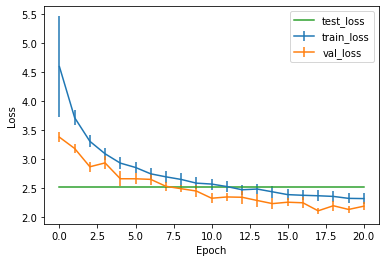

In [15]:
visualizeEpochMeanLoss('train_loss', statistics)
visualizeEpochMeanLoss('val_loss',statistics, skip_first=True)
visualizeTestMeanLoss('train_loss','test_loss',statistics)
plt.legend(loc='upper right', frameon=True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.ylim(1.5,4)
plt.savefig(os.path.join(args.exp_folder, 'loss.png'))
#plt.show()

Plot per Batch Loss

In [ ]:
from matplotlib import pyplot as plt
def visualizeLoss(key, stats):
    batch_stats = stats[key]
    epoch_stats = []
    for key in batch_stats:
        epoch_stats = epoch_stats + list(batch_stats[key].values())
    plt.plot(epoch_stats)

In [ ]:
visualizeLoss('train_loss', statistics)
visualizeLoss('val_loss',statistics)
visualizeLoss('test_loss',statistics)